In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from pyrl.agents.classic.tensorforce import A2CAgent
from pyrl.agents.survival.tensorforce import SurvivalA2CAgent
from pyrl.environments.survival import SurvivalEnv
from pyrl import Sim, Agent, Env, EnvWrapper, System

from pyrl.environments.tf_grid import TFGridEnv, TFGridEnvGUI

from gymnasium.spaces import Discrete, MultiDiscrete

In [2]:
#ENVIRONMENT PARAMETERS

num_cols = 50
num_rows = 5
map_size = (num_cols, num_rows)

minor_r = 5
major_r = 50
step_r = -1

horizon = 5000
gamma = 0.95
batch_size = 32
learning_rate = 0.001

epsilon = 0.7

repeat = 5

# budgets = np.array([100, 200, 300, 400, 500, 600, 700, 800])
budgets = np.array([300, 400, 500, 600, 700, 800])

reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
                  minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}


## Test with rendering

In the next cell, we call a single simulation with visual rendering.

Use `skip_visual_test` to enable or disable it.

In [3]:
skip_visual_test = False

if skip_visual_test:
    
    print("Skipping visual test")
    
else:
    
    env = TFGridEnv(num_rows=num_rows, num_cols=num_cols, 
                  reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
                  render_mode="external")

    initial_budget = 100

    agent_A2C = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=initial_budget,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )

    sim = Sim([agent_A2C], env, episode_horizon=horizon)
    
    
    gui = TFGridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

    gui.launch(give_first_step=True, start_running=True)

    

c:\Users\ayman\miniconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("policy_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("policy_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("policy_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [4]:
def simulation_started_callback(sim):
    #print("START SIM")
    #print(sim.env.observation_shape)
    #print(sim.env.action_shape)
    #print(sim.env.observation_shape + env.action_shape)
    sim.metrics = dict(
        time = 0,
        exploration = np.zeros(sim.env.observation_shape + sim.env.action_shape),
        budget = np.zeros((sim.episode_horizon,), dtype=int)
    )

def simulation_finished_callback(sim):
    print("END SIM")

def episode_started_callback(sim):
    print("START EPISODE")

def episode_finished_callback(sim):
    print("END EPISODE")
    #pass

def round_started_callback(sim):
    #print("START ROUND")
    pass

def round_finished_callback(sim):
    # print("END ROUND")
    sim.metrics["time"] = sim.metrics["time"] + 1
    state_action_index = tuple(np.concatenate( (sim.agent.get_state(), sim.agent.get_action()) ) )
    v = sim.metrics["exploration"].item(state_action_index)
    sim.metrics["exploration"].itemset(state_action_index, v+1)
    sim.metrics["budget"][sim.t-1] = agent.budget

## Massive Tests

In [5]:
env = TFGridEnv(num_rows=num_rows, num_cols=num_cols, 
              reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
              render_mode="human")



In [6]:
a2c_survival_time_mean = np.full(budgets.shape, -1)
a2c_survival_exploration_rate = np.full(budgets.shape, -1)
a2c_survival_alive_rate = np.full(budgets.shape, -1)
a2c_survival_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_max = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_min = np.full(budgets.shape, None)
a2c_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 500
survival_threshold = 250

epsilon = 0.9
learning_rate = 0.5

print("====> Survival A2C with epsilon = ", epsilon, "and exploration threshold and survival thteshold =", (exploration_threshold, survival_threshold))

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = SurvivalA2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        exploration_threshold=exploration_threshold,
                        survival_threshold=survival_threshold,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        # sim.run()
        gui = TFGridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        gui.launch(give_first_step=True, start_running=True)

        if a2c_survival_time_mean[i] == -1:
            a2c_survival_time_mean[i] = sim.metrics["time"]
        else:
            a2c_survival_time_mean[i] = a2c_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_survival_exploration_rate[i] == -1:
            a2c_survival_exploration_rate[i] = exploration_rate
        else:
            a2c_survival_exploration_rate[i] = a2c_survival_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_survival_budget_evolutions_mean[i] is None:
            a2c_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_mean[i] = a2c_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_survival_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_survival_budget_evolutions_max[i] is None:
            a2c_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_max[i] = np.maximum(a2c_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_survival_budget_evolutions_min[i] is None:
            a2c_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_min[i] = np.minimum(a2c_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_survival_exploration_map[i] is None:
            a2c_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_survival_exploration_map[i] = a2c_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_survival_exploration_map[i])

        #print(f"Time mean : {a2c_survival_time_mean[i]}")
        #print(f"Alive rate : {a2c_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {a2c_survival_time_mean[i]}")
        print(f"* alive rate : {a2c_survival_alive_rate[i]}%")
    print("================================================")
    
a2c_survival_250_time_mean = a2c_survival_time_mean
a2c_survival_250_exploration_rate = a2c_survival_exploration_rate
a2c_survival_250_alive_rate = a2c_survival_alive_rate
a2c_survival_250_budget_evolutions_mean = a2c_survival_budget_evolutions_mean
a2c_survival_250_budget_evolutions_max = a2c_survival_budget_evolutions_max
a2c_survival_250_budget_evolutions_min = a2c_survival_budget_evolutions_min
a2c_survival_250_exploration_map = a2c_survival_exploration_map
        

====> Survival A2C with epsilon =  0.9 and exploration threshold and survival thteshold = (500, 250)
Initial Budget : 300
Iteration 1: 
* average survival time : 336
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average survival time : 300
* alive rate : 0%
Iteration 5: 
* average survival time : 300
* alive rate : 0%
Initial Budget : 400
Iteration 1: 
* average survival time : 400
* alive rate : 0%
Iteration 2: 
* average survival time : 400
* alive rate : 0%
Iteration 3: 
* average survival time : 400
* alive rate : 0%
Iteration 4: 
* average survival time : 400
* alive rate : 0%
Iteration 5: 
* average survival time : 400
* alive rate : 0%
Initial Budget : 500
Iteration 1: 
KeyboardInterrupt: simulation interrupted by the user.
* average survival time : 0
* alive rate : 100%
Iteration 2: 


## Classic A2C $\varepsilon = 0.1$

In [ ]:
a2c_time_mean = np.full(budgets.shape, -1)
a2c_exploration_rate = np.full(budgets.shape, -1)
a2c_alive_rate = np.full(budgets.shape, -1)
a2c_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_budget_evolutions_max = np.full(budgets.shape, None)
a2c_budget_evolutions_min = np.full(budgets.shape, None)
a2c_exploration_map = np.full(budgets.shape, None)

epsilon = 0.9

print("====> Classic A2C with epsilon = ", epsilon)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        # sim.run()
        gui = TFGridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        gui.launch(give_first_step=True, start_running=True)
        
        if a2c_time_mean[i] == -1:
            a2c_time_mean[i] = sim.metrics["time"]
        else:
            a2c_time_mean[i] = a2c_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_exploration_rate[i] == -1:
            a2c_exploration_rate[i] = exploration_rate
        else:
            a2c_exploration_rate[i] = a2c_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_budget_evolutions_mean[i] is None:
            a2c_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_mean[i] = a2c_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_budget_evolutions_max[i] is None:
            a2c_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_max[i] = np.maximum(a2c_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_budget_evolutions_min[i] is None:
            a2c_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_min[i] = np.minimum(a2c_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_exploration_map[i] is None:
            a2c_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_exploration_map[i] = a2c_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_exploration_map[i])

        print(f"Time mean : {a2c_time_mean[i]}")
        print(f"Alive rate : {a2c_alive_rate[i]}%")
    print("================================================")


a2c_1_time_mean = a2c_time_mean
a2c_1_exploration_rate = a2c_exploration_rate
a2c_1_alive_rate = a2c_alive_rate
a2c_1_budget_evolutions_mean = a2c_budget_evolutions_mean
a2c_1_budget_evolutions_max = a2c_budget_evolutions_max
a2c_1_budget_evolutions_min = a2c_budget_evolutions_min
a2c_1_exploration_map = a2c_exploration_map

====> Classic A2C with epsilon =  0.9
Initial Budget : 100
Iteration 1: 
Time mean : 100
Alive rate : 0%
Iteration 2: 
Time mean : 100
Alive rate : 0%
Iteration 3: 
Time mean : 100
Alive rate : 0%
Iteration 4: 
Time mean : 100
Alive rate : 0%
Iteration 5: 
Time mean : 100
Alive rate : 0%
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 200
Alive rate : 0%
Iteration 5: 
Time mean : 200
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 300
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 300
Alive rate : 0%
Iteration 5: 
Time mean : 300
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 406
Alive rate : 0%
Iteration 2: 
Time mean : 400
Alive rate : 0%
Iteration 3: 
Time mean : 409
Alive rate : 0%
Iteration 4: 
Time mean : 406
Alive rate : 0%
Iter

## Classic A2C $\varepsilon = 0.3$

In [ ]:
a2c_time_mean = np.full(budgets.shape, -1)
a2c_exploration_rate = np.full(budgets.shape, -1)
a2c_alive_rate = np.full(budgets.shape, -1)
a2c_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_budget_evolutions_max = np.full(budgets.shape, None)
a2c_budget_evolutions_min = np.full(budgets.shape, None)
a2c_exploration_map = np.full(budgets.shape, None)

exploration_rate = 0.3

print("====> Classic A2C with epsilon = ", epsilon)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if a2c_time_mean[i] == -1:
            a2c_time_mean[i] = sim.metrics["time"]
        else:
            a2c_time_mean[i] = a2c_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_exploration_rate[i] == -1:
            a2c_exploration_rate[i] = exploration_rate
        else:
            a2c_exploration_rate[i] = a2c_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_budget_evolutions_mean[i] is None:
            a2c_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_mean[i] = a2c_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_budget_evolutions_max[i] is None:
            a2c_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_max[i] = np.maximum(a2c_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_budget_evolutions_min[i] is None:
            a2c_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_min[i] = np.minimum(a2c_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_exploration_map[i] is None:
            a2c_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_exploration_map[i] = a2c_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_exploration_map[i])

        print(f"Time mean : {a2c_time_mean[i]}")
        print(f"Alive rate : {a2c_alive_rate[i]}%")
    print("================================================")



a2c_3_time_mean = a2c_time_mean
a2c_3_exploration_rate = a2c_exploration_rate
a2c_3_alive_rate = a2c_alive_rate
a2c_3_budget_evolutions_mean = a2c_budget_evolutions_mean
a2c_3_budget_evolutions_max = a2c_budget_evolutions_max
a2c_3_budget_evolutions_min = a2c_budget_evolutions_min
a2c_3_exploration_map = a2c_exploration_map

====> Classic A2C with epsilon =  0.9
Initial Budget : 100
Iteration 1: 
Time mean : 100
Alive rate : 0%
Iteration 2: 
Time mean : 100
Alive rate : 0%
Iteration 3: 
Time mean : 100
Alive rate : 0%
Iteration 4: 
Time mean : 100
Alive rate : 0%
Iteration 5: 
Time mean : 100
Alive rate : 0%
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 200
Alive rate : 0%
Iteration 5: 
Time mean : 200
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 300
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 300
Alive rate : 0%
Iteration 5: 
Time mean : 300
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 400
Alive rate : 0%
Iteration 2: 
Time mean : 412
Alive rate : 0%
Iteration 3: 
Time mean : 406
Alive rate : 0%
Iteration 4: 
Time mean : 410
Alive rate : 0%
Iter

## Classic A2C $\varepsilon = 0.5$

In [ ]:
a2c_time_mean = np.full(budgets.shape, -1)
a2c_exploration_rate = np.full(budgets.shape, -1)
a2c_alive_rate = np.full(budgets.shape, -1)
a2c_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_budget_evolutions_max = np.full(budgets.shape, None)
a2c_budget_evolutions_min = np.full(budgets.shape, None)
a2c_exploration_map = np.full(budgets.shape, None)

epsilon = 0.5

print("====> Classic A2C with epsilon = ", epsilon)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)
        

        if a2c_time_mean[i] == -1:
            a2c_time_mean[i] = sim.metrics["time"]
        else:
            a2c_time_mean[i] = a2c_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_exploration_rate[i] == -1:
            a2c_exploration_rate[i] = exploration_rate
        else:
            a2c_exploration_rate[i] = a2c_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_budget_evolutions_mean[i] is None:
            a2c_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_mean[i] = a2c_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_budget_evolutions_max[i] is None:
            a2c_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_max[i] = np.maximum(a2c_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_budget_evolutions_min[i] is None:
            a2c_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_min[i] = np.minimum(a2c_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_exploration_map[i] is None:
            a2c_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_exploration_map[i] = a2c_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_exploration_map[i])

        print(f"Time mean : {a2c_time_mean[i]}")
        print(f"Alive rate : {a2c_alive_rate[i]}%")
    print("================================================")


a2c_5_time_mean = a2c_time_mean
a2c_5_exploration_rate = a2c_exploration_rate
a2c_5_alive_rate = a2c_alive_rate
a2c_5_budget_evolutions_mean = a2c_budget_evolutions_mean
a2c_5_budget_evolutions_max = a2c_budget_evolutions_max
a2c_5_budget_evolutions_min = a2c_budget_evolutions_min
a2c_5_exploration_map = a2c_exploration_map

====> Classic A2C with epsilon =  0.5
Initial Budget : 100
Iteration 1: 
Time mean : 100
Alive rate : 0%
Iteration 2: 
Time mean : 100
Alive rate : 0%
Iteration 3: 
Time mean : 100
Alive rate : 0%
Iteration 4: 
Time mean : 100
Alive rate : 0%
Iteration 5: 
Time mean : 100
Alive rate : 0%
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 206
Alive rate : 0%
Iteration 4: 
Time mean : 204
Alive rate : 0%
Iteration 5: 
Time mean : 203
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 342
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 300
Alive rate : 0%
Iteration 5: 
Time mean : 306
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 400
Alive rate : 0%
Iteration 2: 
Time mean : 400
Alive rate : 0%
Iteration 3: 
Time mean : 409
Alive rate : 0%
Iteration 4: 
Time mean : 408
Alive rate : 0%
Iter

## Classic A2C greedy

In [ ]:
a2c_time_mean = np.full(budgets.shape, -1)
a2c_exploration_rate = np.full(budgets.shape, -1)
a2c_alive_rate = np.full(budgets.shape, -1)
a2c_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_budget_evolutions_max = np.full(budgets.shape, None)
a2c_budget_evolutions_min = np.full(budgets.shape, None)
a2c_exploration_map = np.full(budgets.shape, None)

epsilon = 0.0

print("====> Classic A2C with epsilon = ", epsilon)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if a2c_time_mean[i] == -1:
            a2c_time_mean[i] = sim.metrics["time"]
        else:
            a2c_time_mean[i] = a2c_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_exploration_rate[i] == -1:
            a2c_exploration_rate[i] = exploration_rate
        else:
            a2c_exploration_rate[i] = a2c_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_budget_evolutions_mean[i] is None:
            a2c_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_mean[i] = a2c_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_budget_evolutions_max[i] is None:
            a2c_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_max[i] = np.maximum(a2c_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_budget_evolutions_min[i] is None:
            a2c_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_min[i] = np.minimum(a2c_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_exploration_map[i] is None:
            a2c_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_exploration_map[i] = a2c_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_exploration_map[i])

        print(f"Time mean : {a2c_time_mean[i]}")
        print(f"Alive rate : {a2c_alive_rate[i]}%")
    print("================================================")


a2c_0_time_mean = a2c_time_mean
a2c_0_exploration_rate = a2c_exploration_rate
a2c_0_alive_rate = a2c_alive_rate
a2c_0_budget_evolutions_mean = a2c_budget_evolutions_mean
a2c_0_budget_evolutions_max = a2c_budget_evolutions_max
a2c_0_budget_evolutions_min = a2c_budget_evolutions_min
a2c_0_exploration_map = a2c_exploration_map

====> Classic A2C with epsilon =  0.0
Initial Budget : 100
Iteration 1: 
Time mean : 100
Alive rate : 0%
Iteration 2: 
Time mean : 100
Alive rate : 0%
Iteration 3: 
Time mean : 100
Alive rate : 0%
Iteration 4: 
Time mean : 100
Alive rate : 0%
Iteration 5: 
Time mean : 100
Alive rate : 0%
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 208
Alive rate : 0%
Iteration 5: 
Time mean : 206
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 312
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 300
Alive rate : 0%
Iteration 4: 
Time mean : 302
Alive rate : 0%
Iteration 5: 
Time mean : 301
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 400
Alive rate : 0%
Iteration 2: 
Time mean : 412
Alive rate : 0%
Iteration 3: 
Time mean : 406
Alive rate : 0%
Iteration 4: 
Time mean : 404
Alive rate : 0%
Iter

## Classic A2C optimistic

In [ ]:
a2c_time_mean = np.full(budgets.shape, -1)
a2c_exploration_rate = np.full(budgets.shape, -1)
a2c_alive_rate = np.full(budgets.shape, -1)
a2c_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_budget_evolutions_max = np.full(budgets.shape, None)
a2c_budget_evolutions_min = np.full(budgets.shape, None)
a2c_exploration_map = np.full(budgets.shape, None)

epsilon=1.0

print("====> Classic A2C with epsilon = ", epsilon)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = A2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)
        

        if a2c_time_mean[i] == -1:
            a2c_time_mean[i] = sim.metrics["time"]
        else:
            a2c_time_mean[i] = a2c_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_exploration_rate[i] == -1:
            a2c_exploration_rate[i] = exploration_rate
        else:
            a2c_exploration_rate[i] = a2c_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_budget_evolutions_mean[i] is None:
            a2c_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_mean[i] = a2c_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_budget_evolutions_max[i] is None:
            a2c_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_max[i] = np.maximum(a2c_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_budget_evolutions_min[i] is None:
            a2c_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_budget_evolutions_min[i] = np.minimum(a2c_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_exploration_map[i] is None:
            a2c_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_exploration_map[i] = a2c_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_exploration_map[i])

        print(f"Time mean : {a2c_time_mean[i]}")
        print(f"Alive rate : {a2c_alive_rate[i]}%")
    print("================================================")



a2c_h_time_mean = a2c_time_mean
a2c_h_exploration_rate = a2c_exploration_rate
a2c_h_alive_rate = a2c_alive_rate
a2c_h_budget_evolutions_mean = a2c_budget_evolutions_mean
a2c_h_budget_evolutions_max = a2c_budget_evolutions_max
a2c_h_budget_evolutions_min = a2c_budget_evolutions_min
a2c_h_exploration_map = a2c_exploration_map

====> Classic A2C with epsilon =  1.0
Initial Budget : 100
Iteration 1: 
Time mean : 100
Alive rate : 0%
Iteration 2: 
Time mean : 100
Alive rate : 0%
Iteration 3: 
Time mean : 100
Alive rate : 0%
Iteration 4: 
Time mean : 100
Alive rate : 0%
Iteration 5: 
Time mean : 100
Alive rate : 0%
Initial Budget : 200
Iteration 1: 
Time mean : 200
Alive rate : 0%
Iteration 2: 
Time mean : 200
Alive rate : 0%
Iteration 3: 
Time mean : 200
Alive rate : 0%
Iteration 4: 
Time mean : 200
Alive rate : 0%
Iteration 5: 
Time mean : 200
Alive rate : 0%
Initial Budget : 300
Iteration 1: 
Time mean : 300
Alive rate : 0%
Iteration 2: 
Time mean : 300
Alive rate : 0%
Iteration 3: 
Time mean : 318
Alive rate : 0%
Iteration 4: 
Time mean : 312
Alive rate : 0%
Iteration 5: 
Time mean : 309
Alive rate : 0%
Initial Budget : 400
Iteration 1: 
Time mean : 400
Alive rate : 0%
Iteration 2: 
Time mean : 400
Alive rate : 0%
Iteration 3: 
Time mean : 403
Alive rate : 0%
Iteration 4: 
Time mean : 408
Alive rate : 0%
Iter

## Survival A2C $w = \{250 - 500\}$

In [ ]:
a2c_survival_time_mean = np.full(budgets.shape, -1)
a2c_survival_exploration_rate = np.full(budgets.shape, -1)
a2c_survival_alive_rate = np.full(budgets.shape, -1)
a2c_survival_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_max = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_min = np.full(budgets.shape, None)
a2c_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 500
survival_threshold = 250

epsilon = 0.4

print("====> Survival A2C with epsilon = ", epsilon, "and exploration threshold and survival thteshold =", (exploration_threshold, survival_threshold))

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        agent = SurvivalA2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        exploration_threshold=exploration_threshold,
                        survival_threshold=survival_threshold,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)

        # gui.launch(give_first_step=True, start_running=True)

        if a2c_survival_time_mean[i] == -1:
            a2c_survival_time_mean[i] = sim.metrics["time"]
        else:
            a2c_survival_time_mean[i] = a2c_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_survival_exploration_rate[i] == -1:
            a2c_survival_exploration_rate[i] = exploration_rate
        else:
            a2c_survival_exploration_rate[i] = a2c_survival_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_survival_budget_evolutions_mean[i] is None:
            a2c_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_mean[i] = a2c_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_survival_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_survival_budget_evolutions_max[i] is None:
            a2c_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_max[i] = np.maximum(a2c_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_survival_budget_evolutions_min[i] is None:
            a2c_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_min[i] = np.minimum(a2c_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_survival_exploration_map[i] is None:
            a2c_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_survival_exploration_map[i] = a2c_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_survival_exploration_map[i])

        #print(f"Time mean : {a2c_survival_time_mean[i]}")
        #print(f"Alive rate : {a2c_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {a2c_survival_time_mean[i]}")
        print(f"* alive rate : {a2c_survival_alive_rate[i]}%")
    print("================================================")
    
a2c_survival_250_time_mean = a2c_survival_time_mean
a2c_survival_250_exploration_rate = a2c_survival_exploration_rate
a2c_survival_250_alive_rate = a2c_survival_alive_rate
a2c_survival_250_budget_evolutions_mean = a2c_survival_budget_evolutions_mean
a2c_survival_250_budget_evolutions_max = a2c_survival_budget_evolutions_max
a2c_survival_250_budget_evolutions_min = a2c_survival_budget_evolutions_min
a2c_survival_250_exploration_map = a2c_survival_exploration_map
        

====> Survival A2C with epsilon =  0.4 and exploration threshold and survival thteshold = (500, 250)
Initial Budget : 100
Iteration 1: 
* average survival time : 100
* alive rate : 0%
Iteration 2: 
* average survival time : 100
* alive rate : 0%
Iteration 3: 
* average survival time : 100
* alive rate : 0%
Iteration 4: 
* average survival time : 100
* alive rate : 0%
Iteration 5: 
* average survival time : 100
* alive rate : 0%
Initial Budget : 200
Iteration 1: 
* average survival time : 200
* alive rate : 0%
Iteration 2: 
* average survival time : 200
* alive rate : 0%
Iteration 3: 
* average survival time : 230
* alive rate : 0%
Iteration 4: 
* average survival time : 220
* alive rate : 0%
Iteration 5: 
* average survival time : 215
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 300
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average surviv

## Survival A2C $w = \{400, 800\}$

In [ ]:
a2c_survival_time_mean = np.full(budgets.shape, -1)
a2c_survival_exploration_rate = np.full(budgets.shape, -1)
a2c_survival_alive_rate = np.full(budgets.shape, -1)
a2c_survival_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_max = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_min = np.full(budgets.shape, None)
a2c_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 800
survival_threshold = 400

print("====> Survival A2C with epsilon = ", epsilon, "and exploration threshold and survival thteshold =", (exploration_threshold, survival_threshold))

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = SurvivalA2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        exploration_threshold=exploration_threshold,
                        survival_threshold=survival_threshold,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)
        # gui.launch(give_first_step=True, start_running=True)
        
        if a2c_survival_time_mean[i] == -1:
            a2c_survival_time_mean[i] = sim.metrics["time"]
        else:
            a2c_survival_time_mean[i] = a2c_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_survival_exploration_rate[i] == -1:
            a2c_survival_exploration_rate[i] = exploration_rate
        else:
            a2c_survival_exploration_rate[i] = a2c_survival_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_survival_budget_evolutions_mean[i] is None:
            a2c_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_mean[i] = a2c_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_survival_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_survival_budget_evolutions_max[i] is None:
            a2c_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_max[i] = np.maximum(a2c_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_survival_budget_evolutions_min[i] is None:
            a2c_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_min[i] = np.minimum(a2c_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_survival_exploration_map[i] is None:
            a2c_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_survival_exploration_map[i] = a2c_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_survival_exploration_map[i])

        #print(f"Time mean : {a2c_survival_time_mean[i]}")
        #print(f"Alive rate : {a2c_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {a2c_survival_time_mean[i]}")
        print(f"* alive rate : {a2c_survival_alive_rate[i]}%")
    print("================================================")
    
a2c_survival_400_time_mean = a2c_survival_time_mean
a2c_survival_400_exploration_rate = a2c_survival_exploration_rate
a2c_survival_400_alive_rate = a2c_survival_alive_rate
a2c_survival_400_budget_evolutions_mean = a2c_survival_budget_evolutions_mean
a2c_survival_400_budget_evolutions_max = a2c_survival_budget_evolutions_max
a2c_survival_400_budget_evolutions_min = a2c_survival_budget_evolutions_min
a2c_survival_400_exploration_map = a2c_survival_exploration_map

====> Survival A2C with epsilon =  0.4 and exploration threshold and survival thteshold = (800, 400)
Initial Budget : 100
Iteration 1: 
* average survival time : 100
* alive rate : 0%
Iteration 2: 
* average survival time : 100
* alive rate : 0%
Iteration 3: 
* average survival time : 100
* alive rate : 0%
Iteration 4: 
* average survival time : 100
* alive rate : 0%
Iteration 5: 
* average survival time : 100
* alive rate : 0%
Initial Budget : 200
Iteration 1: 
* average survival time : 200
* alive rate : 0%
Iteration 2: 
* average survival time : 200
* alive rate : 0%
Iteration 3: 
* average survival time : 200
* alive rate : 0%
Iteration 4: 
* average survival time : 200
* alive rate : 0%
Iteration 5: 
* average survival time : 200
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 300
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average surviv

## Survival A2C $w=\{600 - 1000\}$

In [ ]:
a2c_survival_time_mean = np.full(budgets.shape, -1)
a2c_survival_exploration_rate = np.full(budgets.shape, -1)
a2c_survival_alive_rate = np.full(budgets.shape, -1)
a2c_survival_budget_evolutions_mean = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_max = np.full(budgets.shape, None)
a2c_survival_budget_evolutions_min = np.full(budgets.shape, None)
a2c_survival_exploration_map = np.full(budgets.shape, None)

exploration_threshold = 1000
survival_threshold = 600

print("====> Survival A2C with epsilon = ", epsilon, "and exploration threshold and survival thteshold =", (exploration_threshold, survival_threshold))

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"Initial Budget : {b}")
    for j in range(repeat):
        print(f"Iteration {j+1}: ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = SurvivalA2CAgent(env=env,
                        observation_space=env.observation_space, 
                        action_space=env.action_space,
                        exploration_threshold=exploration_threshold,
                        survival_threshold=survival_threshold,
                        batch_size=batch_size,
                        exploration_rate=epsilon,
                        initial_budget=b,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        )
        sim = Sim(agent, env, episode_horizon=horizon)
        sim.add_listener('simulation_started', simulation_started_callback)
        sim.add_listener('round_finished', round_finished_callback)
        sim.run()
        # gui = GridEnvGUI(sim, cell_size=25, fps=80, close_on_finish=True)
        # gui.launch(give_first_step=True, start_running=True)

        if a2c_survival_time_mean[i] == -1:
            a2c_survival_time_mean[i] = sim.metrics["time"]
        else:
            a2c_survival_time_mean[i] = a2c_survival_time_mean[i] + (1/j) * (sim.metrics["time"] - a2c_survival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.num_obs_comb * env.num_act_comb)) * 100

        if a2c_survival_exploration_rate[i] == -1:
            a2c_survival_exploration_rate[i] = exploration_rate
        else:
            a2c_survival_exploration_rate[i] = a2c_survival_exploration_rate[i] + (1 / j) * (exploration_rate - a2c_survival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        a2c_survival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if a2c_survival_budget_evolutions_mean[i] is None:
            a2c_survival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_mean[i] = a2c_survival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - a2c_survival_budget_evolutions_mean[i])

        # budget evolution max
        if a2c_survival_budget_evolutions_max[i] is None:
            a2c_survival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_max[i] = np.maximum(a2c_survival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if a2c_survival_budget_evolutions_min[i] is None:
            a2c_survival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            a2c_survival_budget_evolutions_min[i] = np.minimum(a2c_survival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if a2c_survival_exploration_map[i] is None:
            a2c_survival_exploration_map[i] = sim.metrics["exploration"]
        else:
            a2c_survival_exploration_map[i] = a2c_survival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - a2c_survival_exploration_map[i])

        #print(f"Time mean : {a2c_survival_time_mean[i]}")
        #print(f"Alive rate : {a2c_survival_alive_rate[i]}%")
        
        print(f"* average survival time : {a2c_survival_time_mean[i]}")
        print(f"* alive rate : {a2c_survival_alive_rate[i]}%")
    print("================================================")

    
a2c_survival_600_time_mean = a2c_survival_time_mean
a2c_survival_600_exploration_rate = a2c_survival_exploration_rate
a2c_survival_600_alive_rate = a2c_survival_alive_rate
a2c_survival_600_budget_evolutions_mean = a2c_survival_budget_evolutions_mean
a2c_survival_600_budget_evolutions_max = a2c_survival_budget_evolutions_max
a2c_survival_600_budget_evolutions_min = a2c_survival_budget_evolutions_min
a2c_survival_600_exploration_map = a2c_survival_exploration_map

====> Survival A2C with epsilon =  0.4 and exploration threshold and survival thteshold = (1000, 600)
Initial Budget : 100
Iteration 1: 
* average survival time : 100
* alive rate : 0%
Iteration 2: 
* average survival time : 100
* alive rate : 0%
Iteration 3: 
* average survival time : 100
* alive rate : 0%
Iteration 4: 
* average survival time : 100
* alive rate : 0%
Iteration 5: 
* average survival time : 100
* alive rate : 0%
Initial Budget : 200
Iteration 1: 
* average survival time : 200
* alive rate : 0%
Iteration 2: 
* average survival time : 200
* alive rate : 0%
Iteration 3: 
* average survival time : 203
* alive rate : 0%
Iteration 4: 
* average survival time : 202
* alive rate : 0%
Iteration 5: 
* average survival time : 201
* alive rate : 0%
Initial Budget : 300
Iteration 1: 
* average survival time : 300
* alive rate : 0%
Iteration 2: 
* average survival time : 300
* alive rate : 0%
Iteration 3: 
* average survival time : 300
* alive rate : 0%
Iteration 4: 
* average survi

## Results

### Survival time

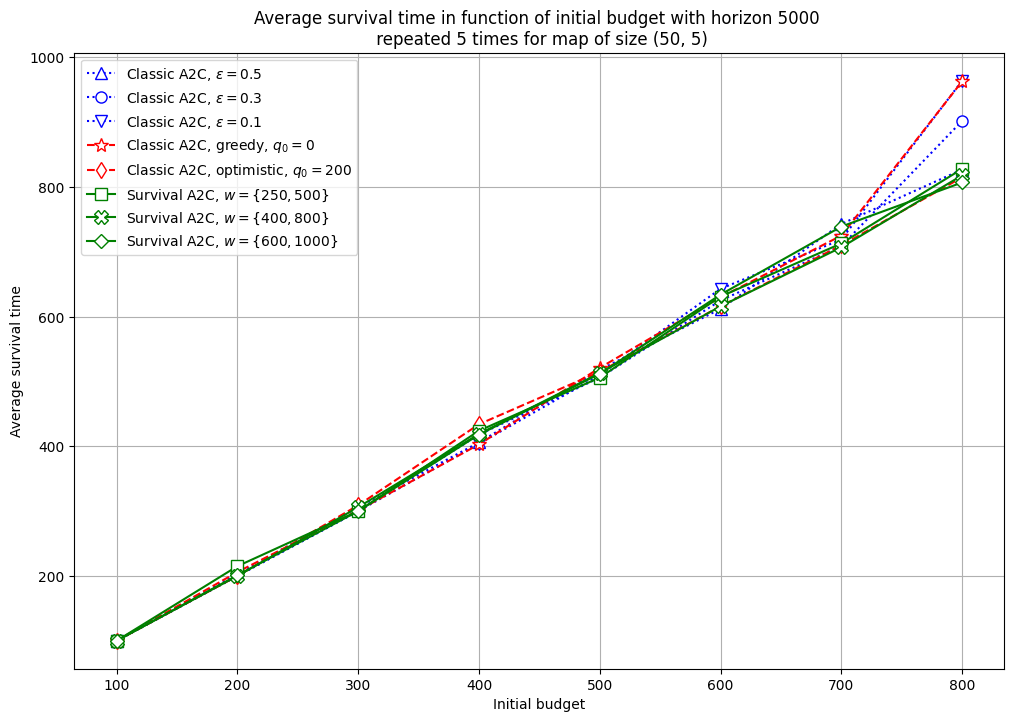

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, a2c_5_time_mean, label=f"Classic A2C, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_3_time_mean, label=f"Classic A2C, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_1_time_mean, label=f"Classic A2C, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_0_time_mean, label=f"Classic A2C, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_h_time_mean, label=f"Classic A2C, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_250_time_mean, label="Survival A2C, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_400_time_mean, label="Survival A2C, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_survival_600_time_mean, label="Survival A2C, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Average survival time")
plt.legend()
plt.grid()
plt.title(f"Average survival time in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")  #and survival threshold [{survival_threshold}-{exploration_threshold}] 
plt.show()

### Alive rate

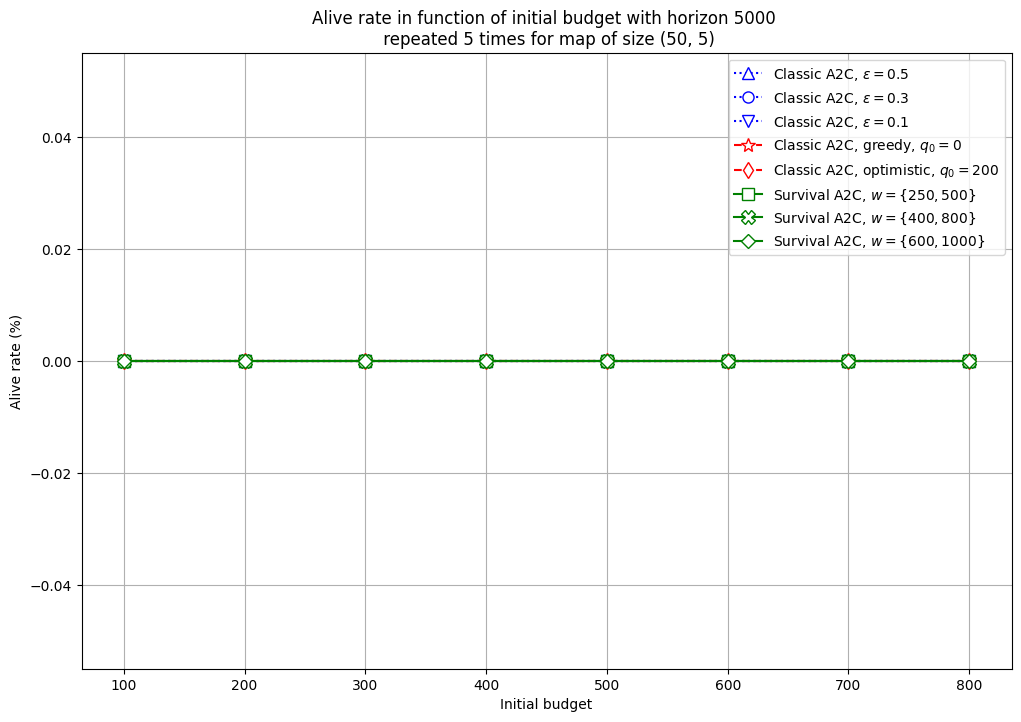

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, a2c_5_alive_rate, label=f"Classic A2C, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_3_alive_rate, label=f"Classic A2C, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_1_alive_rate, label=f"Classic A2C, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_0_alive_rate, label=f"Classic A2C, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_h_alive_rate, label=f"Classic A2C, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_250_alive_rate, label="Survival A2C, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_400_alive_rate, label="Survival A2C, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_survival_600_alive_rate, label="Survival A2C, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.grid()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Exploration rate

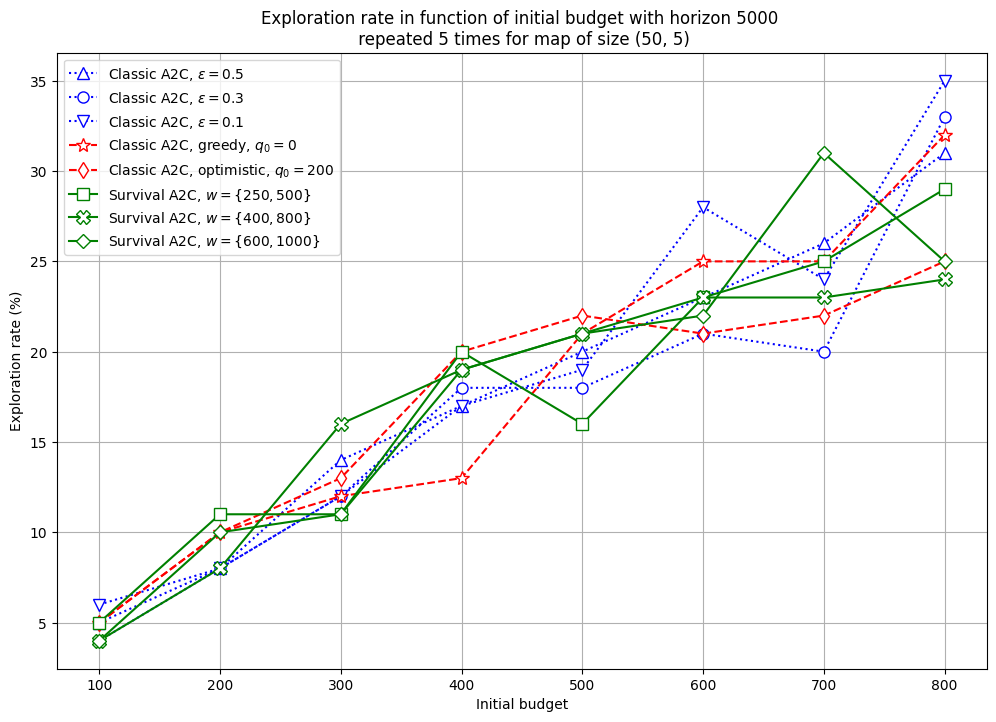

In [ ]:
fig = plt.figure(figsize=(12, 8))
#plt.plot(budgets, cde_exploration_rate, label="CDELearning")
plt.plot(budgets, a2c_5_exploration_rate, label=f"Classic A2C, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_3_exploration_rate, label=f"Classic A2C, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_1_exploration_rate, label=f"Classic A2C, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, a2c_0_exploration_rate, label=f"Classic A2C, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_h_exploration_rate, label=f"Classic A2C, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_250_exploration_rate, label="Survival A2C, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, a2c_survival_400_exploration_rate, label="Survival A2C, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, a2c_survival_600_exploration_rate, label="Survival A2C, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.grid()
plt.title(f"Exploration rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Budget evolution

In [ ]:
print("Available budgets :")
print(budgets)

#plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = [300, 400, 500]
colors = ['r', 'g', 'b']


Available budgets :
[100 200 300 400 500 600 700 800]


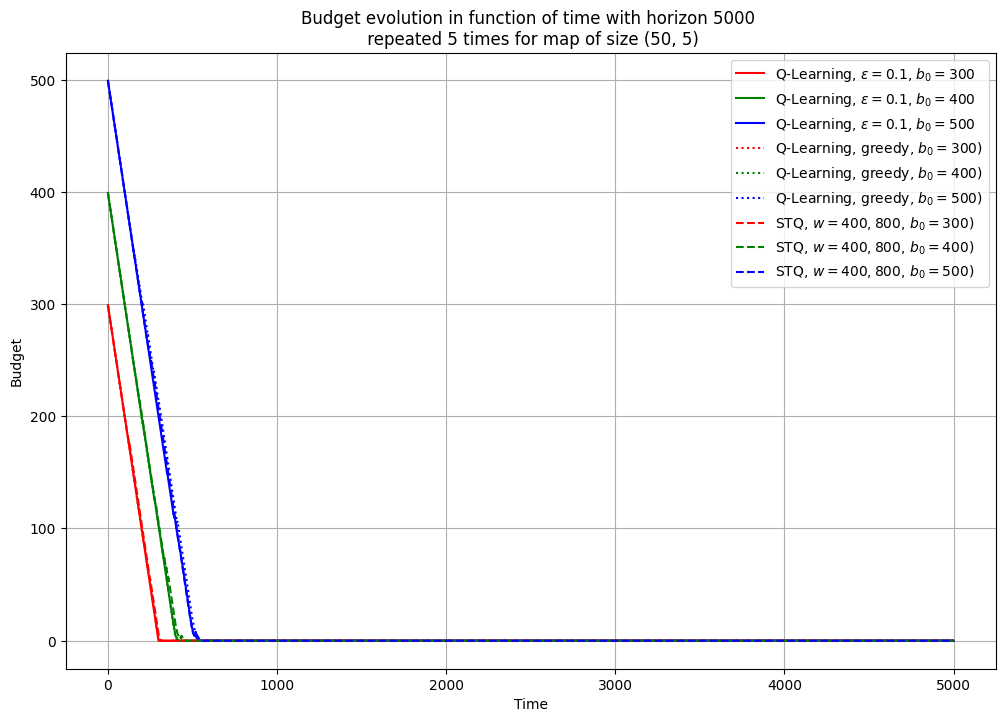

In [ ]:
t = np.arange(horizon)

fig = plt.figure(figsize=(12, 8))

n=0
for i, evo in enumerate(a2c_1_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, $\\varepsilon=0.1$, $b_0=${budgets[i]}", ls='-', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, a2c_1_budget_evolutions_min[i], a2c_1__budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

n=0
for i, evo in enumerate(a2c_0_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, greedy, $b_0=${budgets[i]})", ls=':', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, a2c_0_budget_evolutions_min[i], a2c_0_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)
            
n=0
for i, evo in enumerate(a2c_survival_400_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"STQ, $w={{400, 800}}$, $b_0=${budgets[i]})", ls='--', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, a2c_survival_400_budget_evolutions_min[i], a2c_survival_400_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

#plt.yscale('symlog')

#plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}", ls="-.")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

In [ ]:
from pyrl.agents.classic import A2CAgent
from pyrl.agents.survival import SurvivalA2CAgent
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

from tensorforce.agents import Agent
from tensorforce.environments import Environment
from pyrl.environments import CustomEnvironment
from tensorforce.execution import Runner

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from tensorforce.agents import Agent as TFAgent
from tensorforce.core.networks import AutoNetwork


ImportError: cannot import name 'A2CAgent' from 'pyrl.agents.classic' (c:\users\ayman\desktop\pyrl\src\pyrl\agents\classic\__init__.py)

In [ ]:
map_size = (50, 5)
horizon = 5000
points = 6
repeat = 3
survival_threshold = 250
exploration_threshold = 500
gamma = 0.99 # discount factor
initial_budgets = np.linspace(100, horizon, points, dtype=int)

batch_size = 32
exploration_rate = 0.9
learning_rate = 0.001
update_frequency = 1.0

In [ ]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon
)

survival_dqn_time_mean = np.full(initial_budgets.shape, -1)
survival_dqn_exploration_rate = np.full(initial_budgets.shape, -1)
survival_dqn_alive_rate = np.full(initial_budgets.shape, -1)
survival_dqn_budget_evolutions = list()

survival_dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Survival A2C {b} | Try {j + 1}")
        states = env.reset()
        
        agent = SurvivalA2CAgent(environment=env,
                         initial_observation=states,
                         batch_size=batch_size,
                         initial_budget=b,
                         horizon=horizon,
                         exploration=exploration_rate,
                         discount=gamma,
                         update_frequency=update_frequency,
                         learning_rate=learning_rate,
                        )
        
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward= env.execute(actions=actions)
            done = terminated or t >= horizon or agent.b <= 0
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            agent.observe(states, reward, terminated=terminated)            
            env.render()
            
            budget_evolution[t-1] = agent.b

            if done:
                print("t = ", t)
                if survival_dqn_time_mean[i] == -1:
                    survival_dqn_time_mean[i] = t
                else:
                    survival_dqn_time_mean[i] = survival_dqn_time_mean[i] + (1/(j+1)) * (t - survival_dqn_time_mean[i])
                break
        
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if survival_dqn_exploration_rate[i] == -1:
            survival_dqn_exploration_rate[i] = exploration_rate
        else:
            survival_dqn_exploration_rate[i] = survival_dqn_exploration_rate[i] + (1 / (j+1)) * (exploration_rate - survival_dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        survival_dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if survival_dqn_budget_evolutions_mean[i] is None:
            survival_dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_mean[i] = survival_dqn_budget_evolutions_mean[i] + (1 / (j+1)) * (budget_evolution - survival_dqn_budget_evolutions_mean[i])

        # budget evolution max
        if survival_dqn_budget_evolutions_max[i] is None:
            survival_dqn_budget_evolutions_max[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_max[i] = np.maximum(survival_dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if survival_dqn_budget_evolutions_min[i] is None:
            survival_dqn_budget_evolutions_min[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_min[i] = np.minimum(survival_dqn_budget_evolutions_min[i], budget_evolution)
        
        print(f"Time mean : {survival_dqn_time_mean[i]}")
        print(f"Alive rate : {survival_dqn_alive_rate[i]}%")
        print(f"Exploration rate: {survival_dqn_exploration_rate[i]}%")

====> Survival A2C 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 6%
====> Survival A2C 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Survival A2C 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 4%
====> Survival A2C 1080 | Try 1
t =  1122
Time mean : 1122
Alive rate : 0%
Exploration rate: 43%
====> Survival A2C 1080 | Try 2
t =  1122
Time mean : 1122
Alive rate : 0%
Exploration rate: 47%
====> Survival A2C 1080 | Try 3
t =  1080
Time mean : 1108
Alive rate : 0%
Exploration rate: 37%
====> Survival A2C 2060 | Try 1
t =  2066
Time mean : 2066
Alive rate : 0%
Exploration rate: 44%
====> Survival A2C 2060 | Try 2
t =  2312
Time mean : 2189
Alive rate : 0%
Exploration rate: 52%
====> Survival A2C 2060 | Try 3
t =  2138
Time mean : 2172
Alive rate : 0%
Exploration rate: 48%
====> Survival A2C 3040 | Try 1
t =  4999
Time mean : 4999
Alive rate : 100%
Exploration rate: 86%
====> Survival A2C 3040 | Try 2
t =  361

In [ ]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon,
)

dqn_time_mean = np.full(initial_budgets.shape, -1)
dqn_exploration_rate = np.full(initial_budgets.shape, -1)
dqn_alive_rate = np.full(initial_budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Classic A2C {b} | Try {j + 1}")
        states = env.reset()
        
        agent = A2CAgent(environment=env,
                         initial_observation=states,
                         batch_size=batch_size,
                         initial_budget=b,
                         horizon=horizon,
                         exploration=exploration_rate,
                         discount=gamma,
                         update_frequency=update_frequency,
                         learning_rate=learning_rate,
                        )
                         
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward = env.execute(actions=actions)
            done = terminated or t >= horizon or agent.b <= 0
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            agent.observe(states, reward, terminated=terminated)
            env.render()
            
            budget_evolution[t-1] = agent.b
            
            if done:
                print("t = ", t)
                if dqn_time_mean[i] == -1:
                    dqn_time_mean[i] = t
                else:
                    dqn_time_mean[i] = dqn_time_mean[i] + (1/(j+1)) * (t - dqn_time_mean[i])
                
                break
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1/(j+1)) * (exploration_rate - dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100
        
         # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1/(j+1)) * (budget_evolution - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = budget_evolution
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = budget_evolution
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], budget_evolution)
        

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
        print(f"Exploration rate: {dqn_exploration_rate[i]}%")

====> Classic A2C 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Classic A2C 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Classic A2C 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 4%
====> Classic A2C 1080 | Try 1
t =  1599
Time mean : 1599
Alive rate : 0%
Exploration rate: 58%
====> Classic A2C 1080 | Try 2
t =  1104
Time mean : 1351
Alive rate : 0%
Exploration rate: 44%
====> Classic A2C 1080 | Try 3
t =  1104
Time mean : 1268
Alive rate : 0%
Exploration rate: 38%
====> Classic A2C 2060 | Try 1
t =  2114
Time mean : 2114
Alive rate : 0%
Exploration rate: 32%
====> Classic A2C 2060 | Try 2
t =  3590
Time mean : 2852
Alive rate : 0%
Exploration rate: 55%
====> Classic A2C 2060 | Try 3
t =  2126
Time mean : 2610
Alive rate : 0%
Exploration rate: 47%
====> Classic A2C 3040 | Try 1
t =  4729
Time mean : 4729
Alive rate : 0%
Exploration rate: 86%
====> Classic A2C 3040 | Try 2
t =  3088
Time mean :

## Results

### Survival time

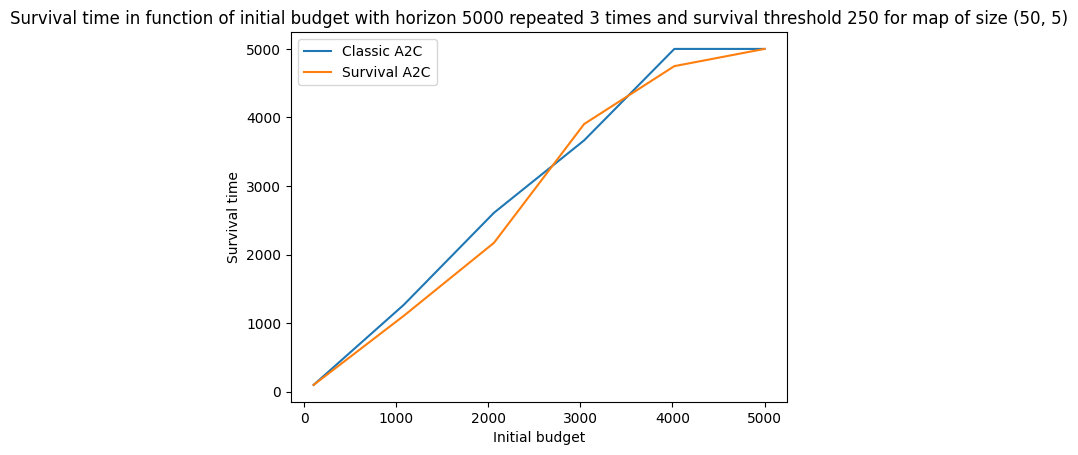

In [ ]:
plt.plot(initial_budgets, dqn_time_mean, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_time_mean, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Survival time")
plt.legend()
plt.title(f"Survival time in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Alive rate

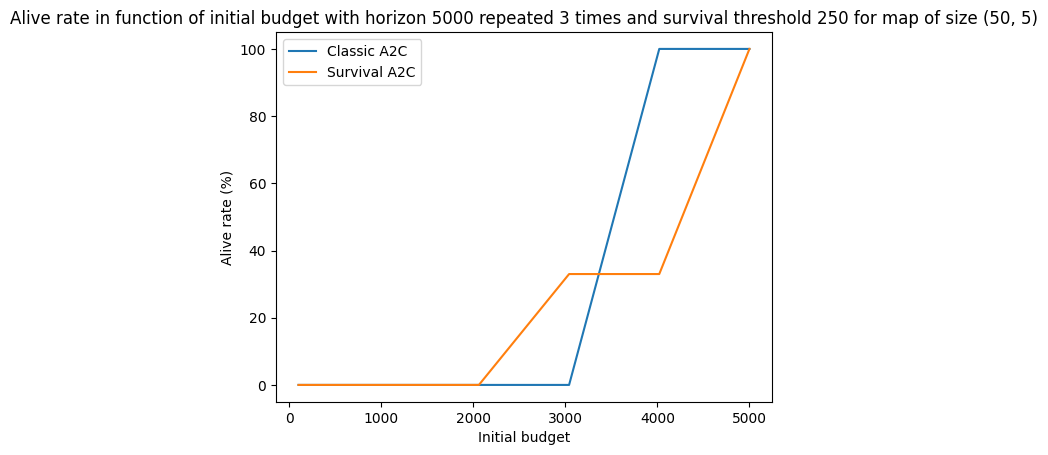

In [ ]:
plt.plot(initial_budgets, dqn_alive_rate, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_alive_rate, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Exploration rate

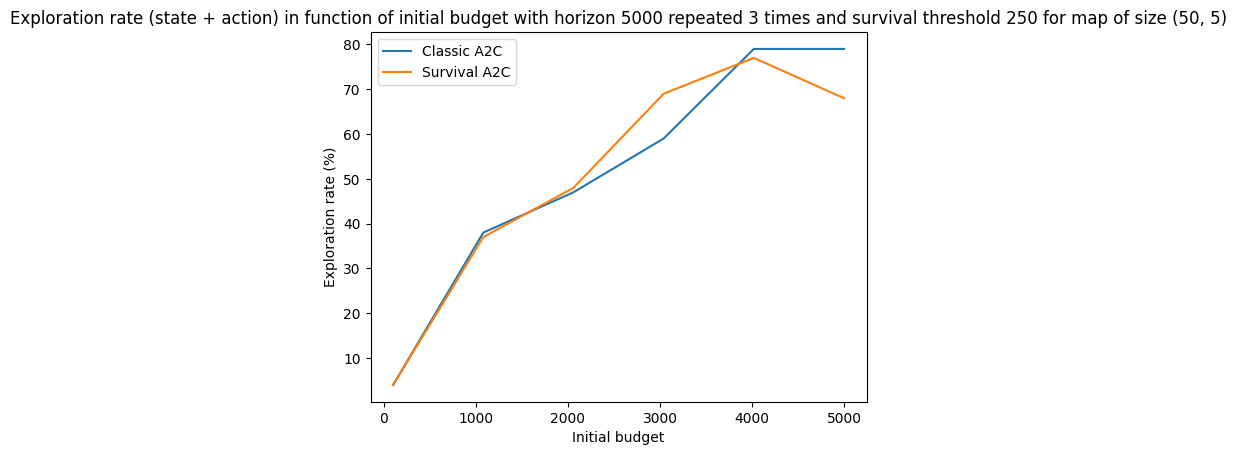

In [ ]:
plt.plot(initial_budgets, dqn_exploration_rate, label="Classic A2C")
plt.plot(initial_budgets, survival_dqn_exploration_rate, label="Survival A2C")
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.title(f"Exploration rate (state + action) in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Budget evolution

In [ ]:
print("Available budgets :")
print(initial_budgets)

Available budgets :
[ 100 1080 2060 3040 4020 5000]


In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = []

#### Classic DQN

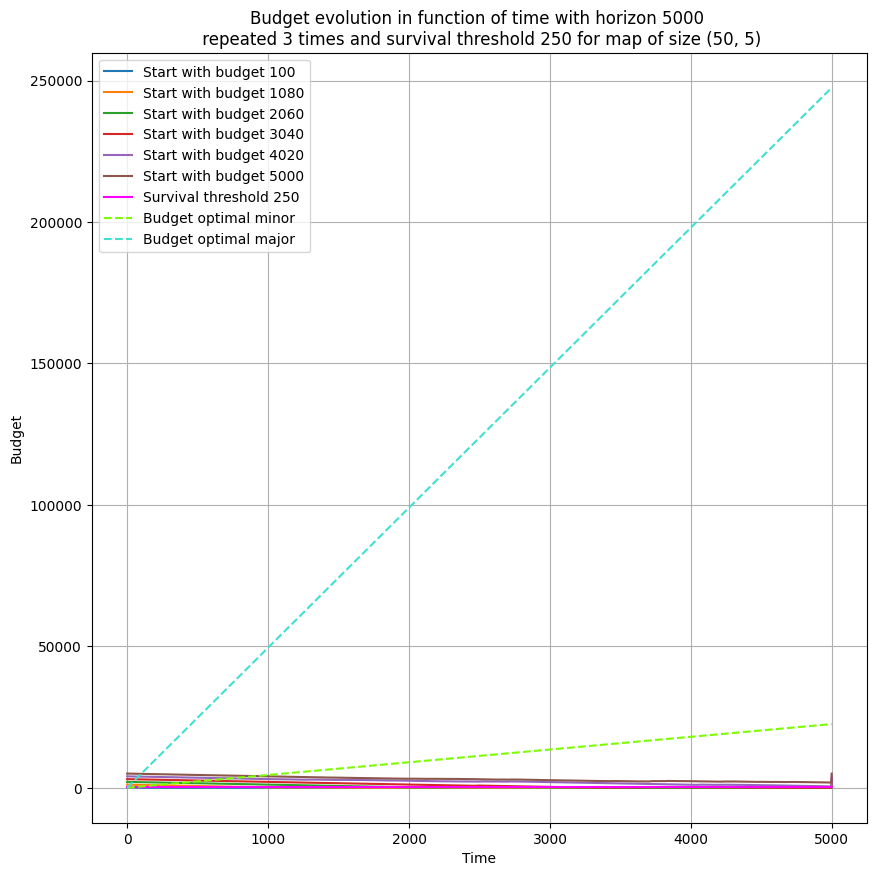

In [ ]:
t = np.arange(horizon)

for i, evo in enumerate(dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, dqn_budget_evolutions_min[i], dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

#### Survival DQN

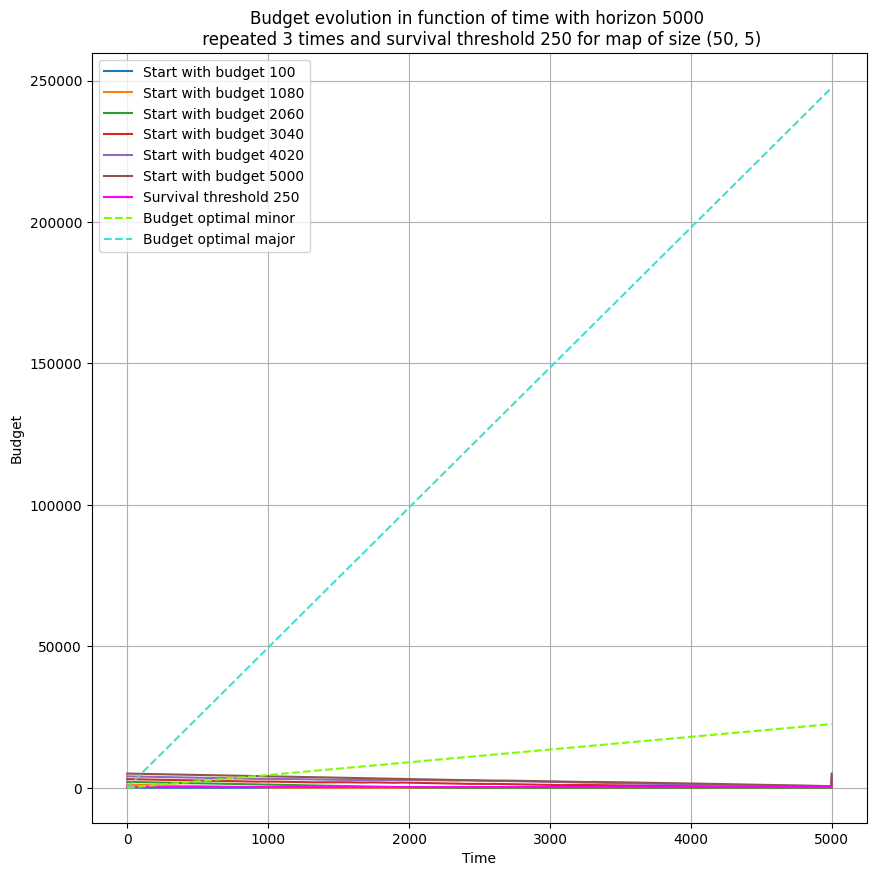

In [ ]:
import matplotlib.colors as mcolors

t = np.arange(horizon)

for i, evo in enumerate(survival_dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, survival_dqn_budget_evolutions_min[i], survival_dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()